In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tastyyfood/Food/pavbhaji.jpg
/kaggle/input/tastyyfood/Food/munchurian.jpg
/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg
/kaggle/input/tastyyfood/Food/vegetable-noodles.jpg
/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg
/kaggle/input/tastyyfood/Food/cheese_burstpizza.jpeg
/kaggle/input/tastyyfood/Food/chicken_biryani.jpg
/kaggle/input/tastyyfood/Food/chicken_momo.jpg
/kaggle/input/tastyyfood/Food/american-style-pancakes-87119e3.jpg
/kaggle/input/tastyyfood/Food/rajmachawal.jpg
/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg
/kaggle/input/tastyyfood/Food/white-sauce-pasta-recipe.jpg
/kaggle/input/tastyyfood/Food/honeychilli.jpg
/kaggle/input/tastyyfood/Food/shahipaneer.jpg
/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg


In [1]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 69.9 MB/s eta 0:00:00:00:0100:01


In [5]:
import math
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer,AutoConfig

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    config = AutoConfig.from_pretrained("OpenGVLab/InternVL3-2B", trust_remote_code=True)
    num_layers = config.llm_config.num_hidden_layers
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

# If you set `load_in_8bit=True`, you will need two 80GB GPUs.
# If you set `load_in_8bit=False`, you will need at least three 80GB GPUs.
path = 'OpenGVLab/InternVL3-2B'
device_map = split_model('InternVL3-2B')
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=False,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map=device_map).eval()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)


config.json:   0%|          | 0.00/6.33k [00:00<?, ?B/s]

configuration_internvl_chat.py:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL3-2B:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL3-2B:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

modeling_intern_vit.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL3-2B:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL3-2B:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL3-2B:
- modeling_internvl_chat.py
- modeling_intern_vit.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
2025-05-29 15:31:31.334408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748532691.826614      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174853

FlashAttention2 is not installed.


model.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

image_path                    Title  \
0  /kaggle/input/tastyyfood/Food/Cheese-omelette-...  Melted Morning Surprise   

                                   full_instructions  \
0  Step 1: Whisk eggs in a bowl; add milk and sea...   

                                    Dish_at_a_Glance  
0  Whisk eggs with milk and seasonings until foam...

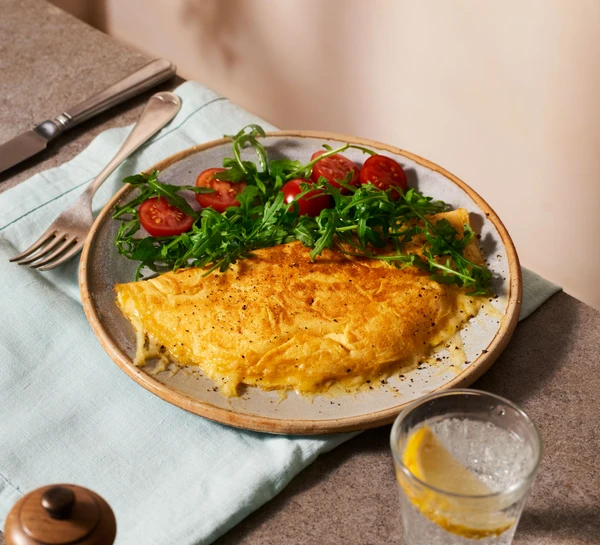

image_path                Title  \
1  /kaggle/input/tastyyfood/Food/Chicken-Tikka-99...  Spice Stick Fantasy   

                                   full_instructions  \
1  Step 1: Cut chicken into bite-sized pieces. Ta...   

                                    Dish_at_a_Glance  
1  Marinate chicken chunks in spiced yogurt mixtu...

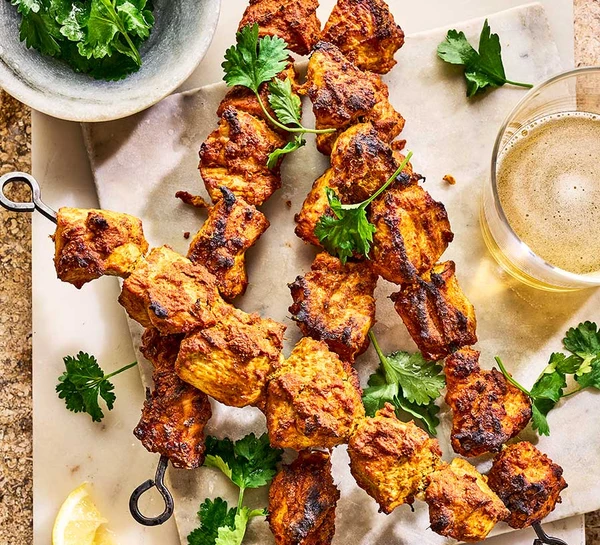

image_path                  Title  \
2  /kaggle/input/tastyyfood/Food/Chole_Bhature_At...  Street Style Favorite   

                                   full_instructions  \
2  Step 1: Soak chickpeas overnight. Take your ti...   

                                    Dish_at_a_Glance  
2  Cook soaked chickpeas with spices and tea bags...

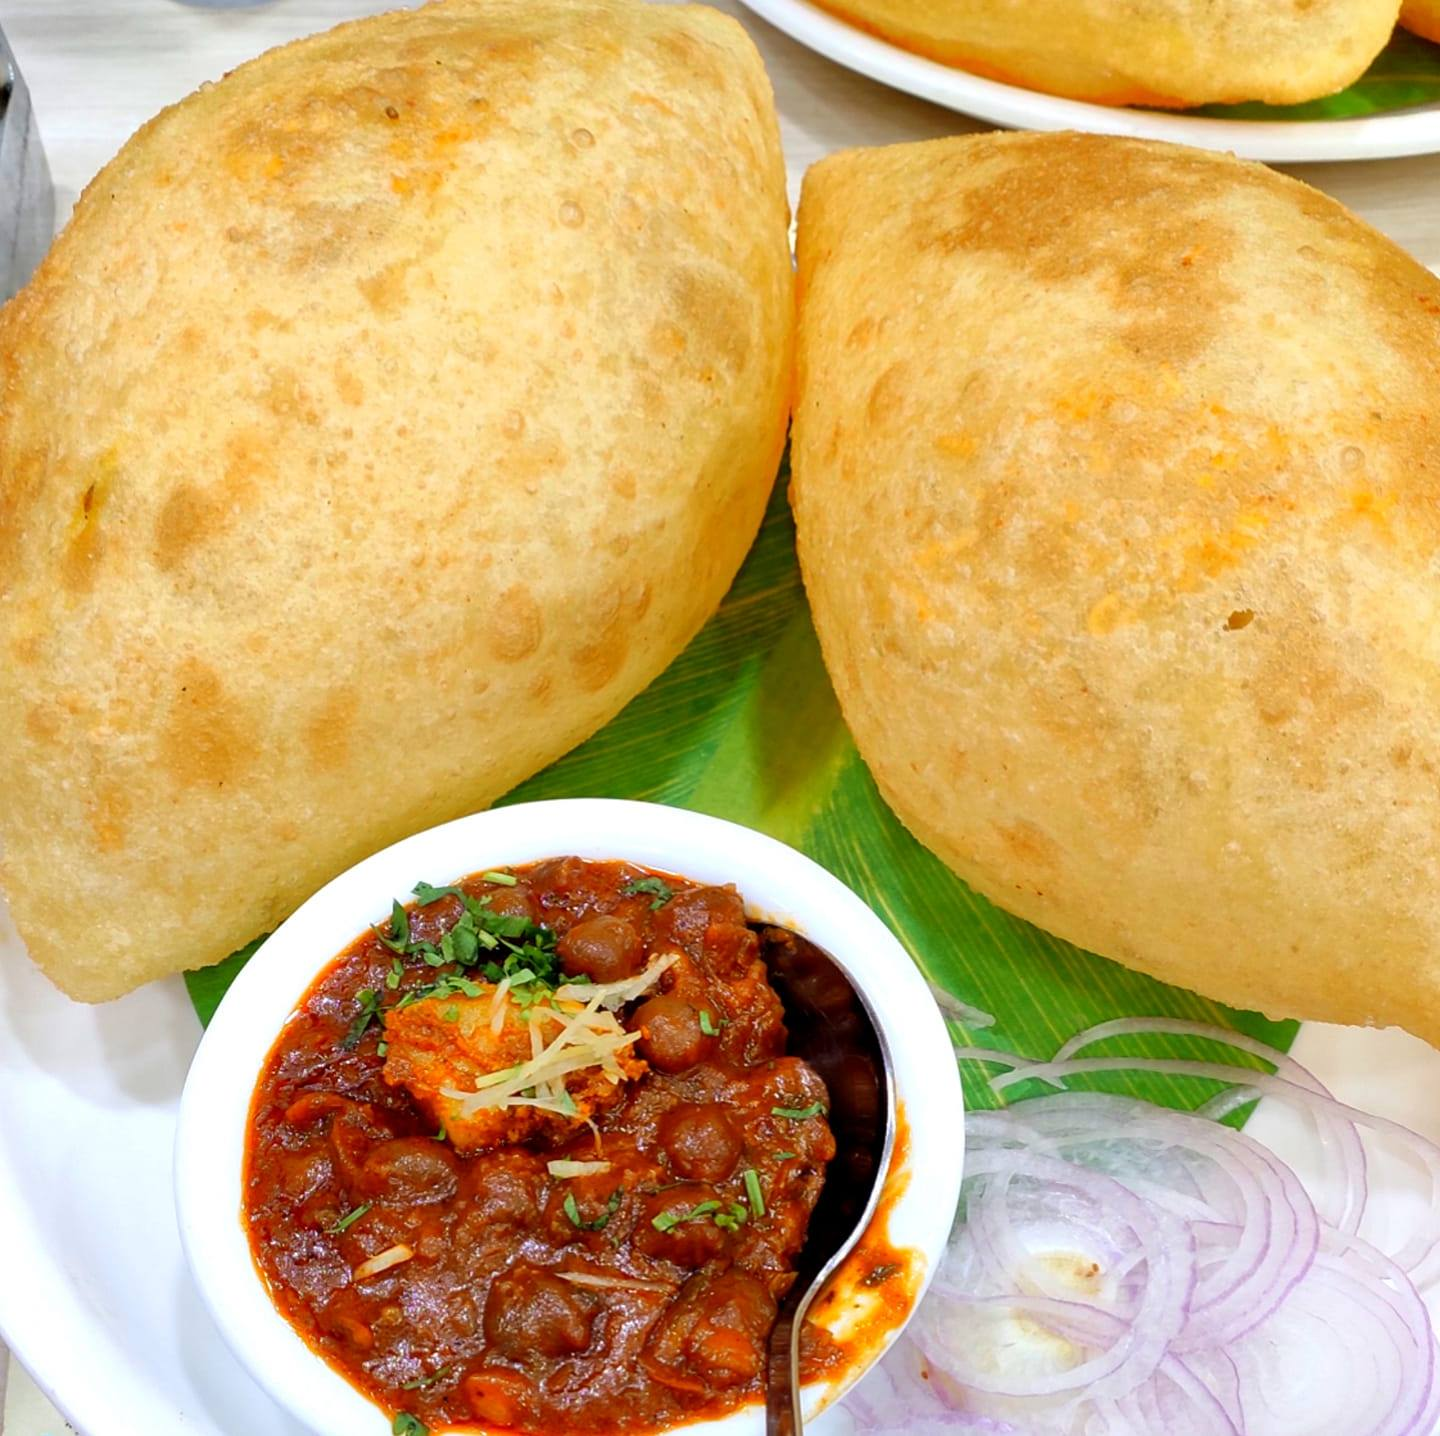

image_path                Title  \
3  /kaggle/input/tastyyfood/Food/Secret-Veg-Chees...  Veggie Crunch Stack   

                                   full_instructions  \
3  Step 1: Mix mashed potatoes, carrots, beans, c...   

                                    Dish_at_a_Glance  
3  Mix mashed veggies with spices and breadcrumbs...

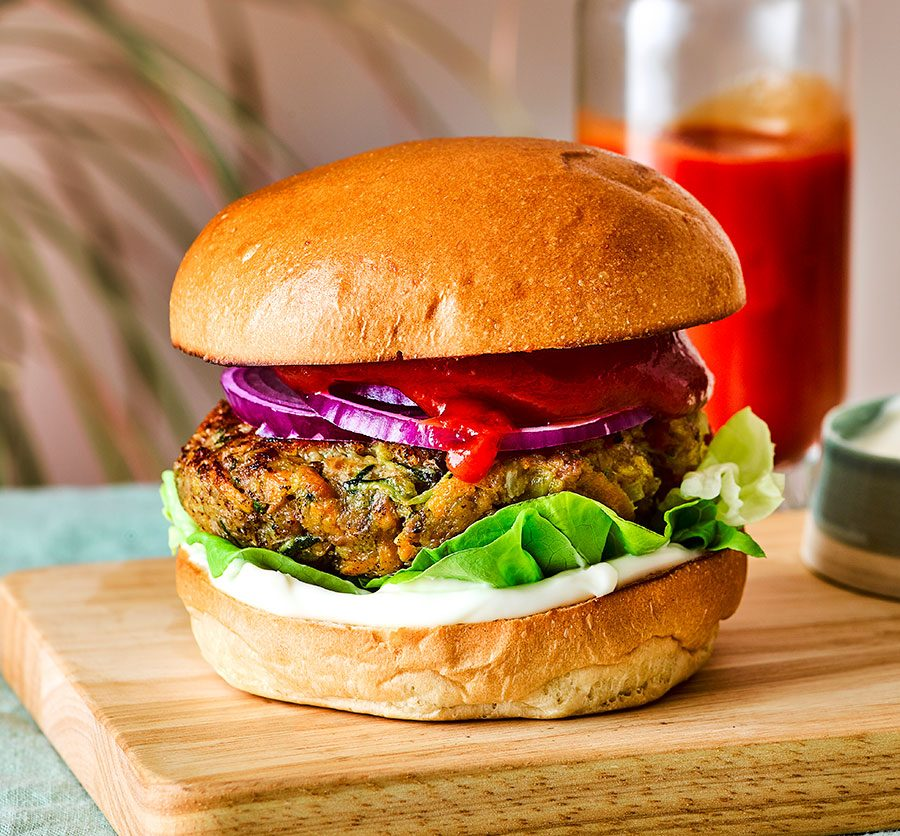

image_path                  Title  \
4  /kaggle/input/tastyyfood/Food/american-style-p...  Morning Griddle Flips   

                                   full_instructions  \
4  Step 1: Mix flour, sugar, baking powder, and s...   

                                    Dish_at_a_Glance  
4  Mix batter from flour, sugar, baking powder, m...

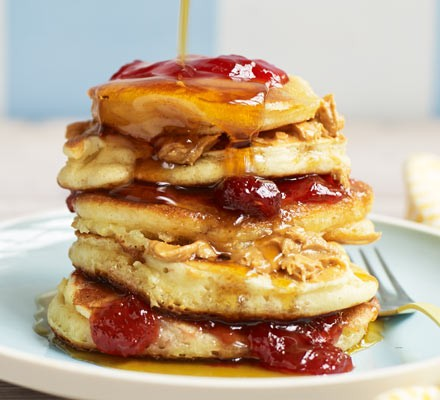

image_path                 Title  \
5  /kaggle/input/tastyyfood/Food/cheese_burstpizz...  Cheese Burst Classic   

                                   full_instructions  \
5  Step 1: Prepare pizza dough and let it rise. T...   

                                    Dish_at_a_Glance  
5  Prepare pizza dough, top with tomato sauce, ch...

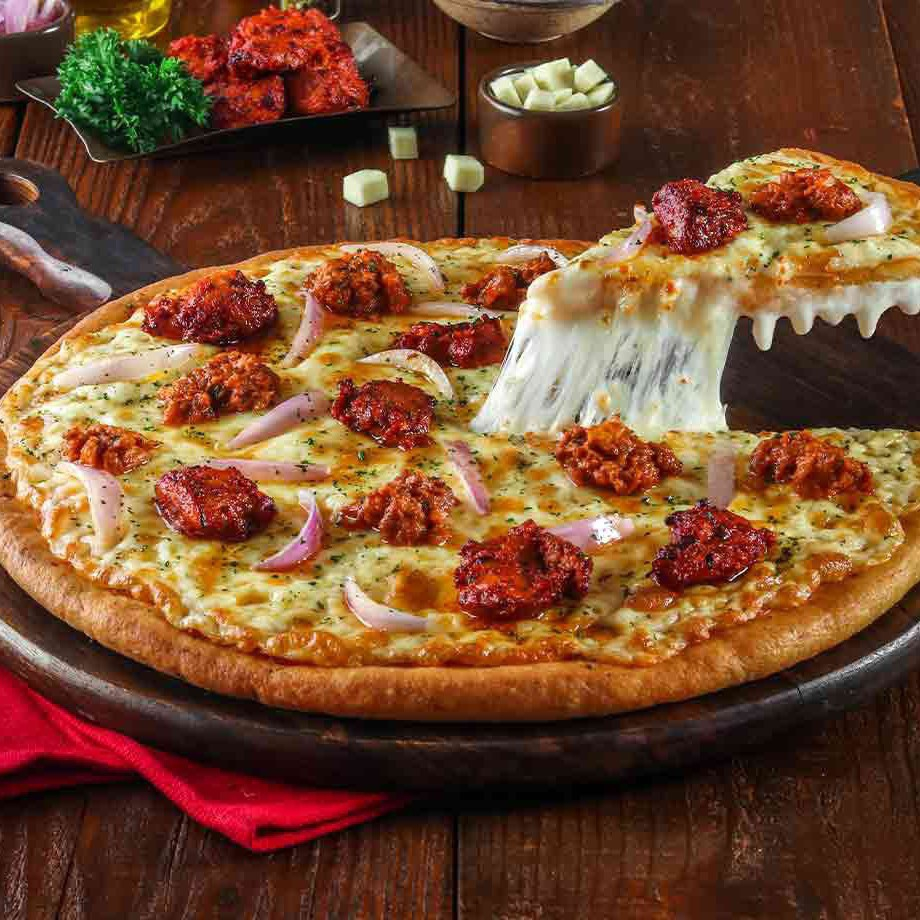

image_path              Title  \
6  /kaggle/input/tastyyfood/Food/chicken_biryani.jpg  Layered Aroma Pot   

                                   full_instructions  \
6  Step 1: Marinate chicken with yogurt, spices, ...   

                                    Dish_at_a_Glance  
6  Marinate chicken with yogurt and spices, soak ...

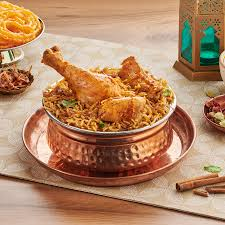

image_path                  Title  \
7  /kaggle/input/tastyyfood/Food/chicken_momo.jpg  Steamed Pocket Treats   

                                   full_instructions  \
7  Step 1: Mix minced chicken, onions, garlic, gi...   

                                    Dish_at_a_Glance  
7  Mix minced chicken with spices, prepare dough,...

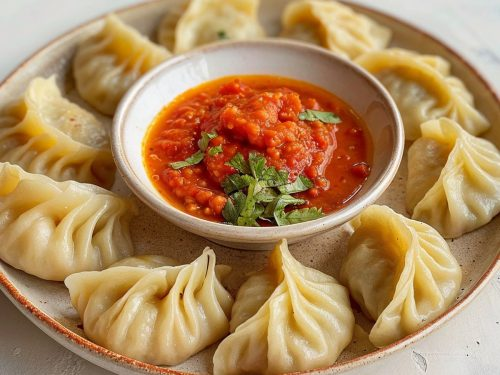

image_path              Title  \
8  /kaggle/input/tastyyfood/Food/honeychilli.jpg  Crispy Glaze Toss   

                                   full_instructions  \
8  Step 1: Cut potatoes into strips and deep fry ...   

                                    Dish_at_a_Glance  
8  Deep-fry potato strips until crispy, sauté aro...

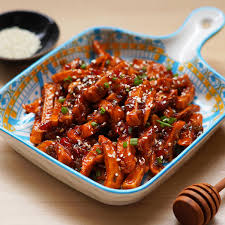

image_path             Title  \
9  /kaggle/input/tastyyfood/Food/munchurian.jpg  Golden Globe Mix   

                                   full_instructions  \
9  Step 1: Grate and mix vegetables with flour an...   

                                    Dish_at_a_Glance  
9  Grate vegetables, mix with flour and spices, s...

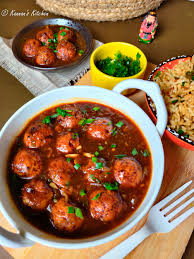

image_path                 Title  \
10  /kaggle/input/tastyyfood/Food/pavbhaji.jpg  Mash and Toast Combo   

                                    full_instructions  \
10  Step 1: Boil and mash mixed vegetables. Take y...   

                                     Dish_at_a_Glance  
10  Boil and mash mixed vegetables, cook with spic...

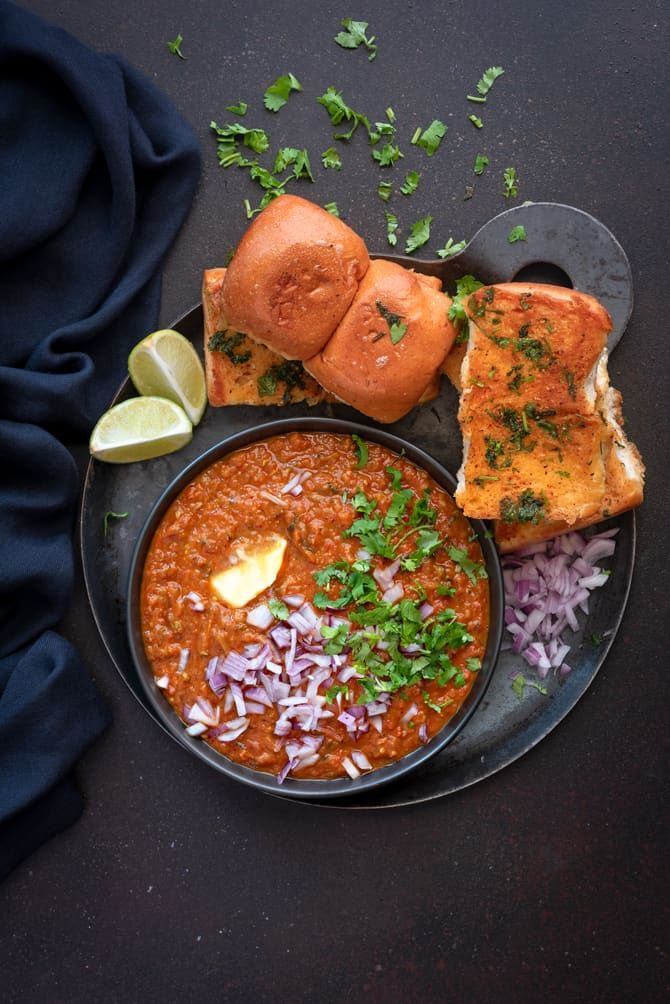

image_path              Title  \
11  /kaggle/input/tastyyfood/Food/rajmachawal.jpg  Warm Bowl Comfort   

                                    full_instructions  \
11  Step 1: Soak kidney beans overnight. Take your...   

                                     Dish_at_a_Glance  
11  Soak and pressure cook kidney beans, sauté oni...

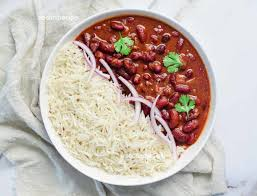

image_path             Title  \
12  /kaggle/input/tastyyfood/Food/shahipaneer.jpg  Creamy Cubes Mix   

                                    full_instructions  \
12  Step 1: Sauté onions, garlic, ginger, and toma...   

                                     Dish_at_a_Glance  
12  Sauté aromatics, blend into paste, add cream, ...

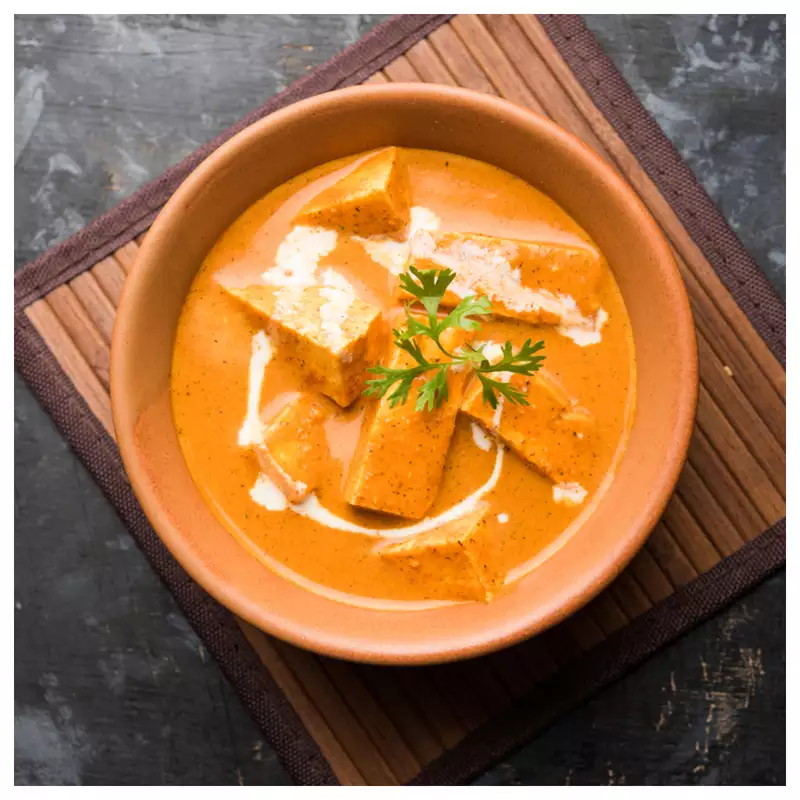

image_path           Title  \
13  /kaggle/input/tastyyfood/Food/vegetable-noodle...  Quick Toss Fix   

                                    full_instructions  \
13  Step 1: Boil noodles and drain. Take your time...   

                                     Dish_at_a_Glance  
13  Boil noodles, stir-fry garlic, ginger, and veg...

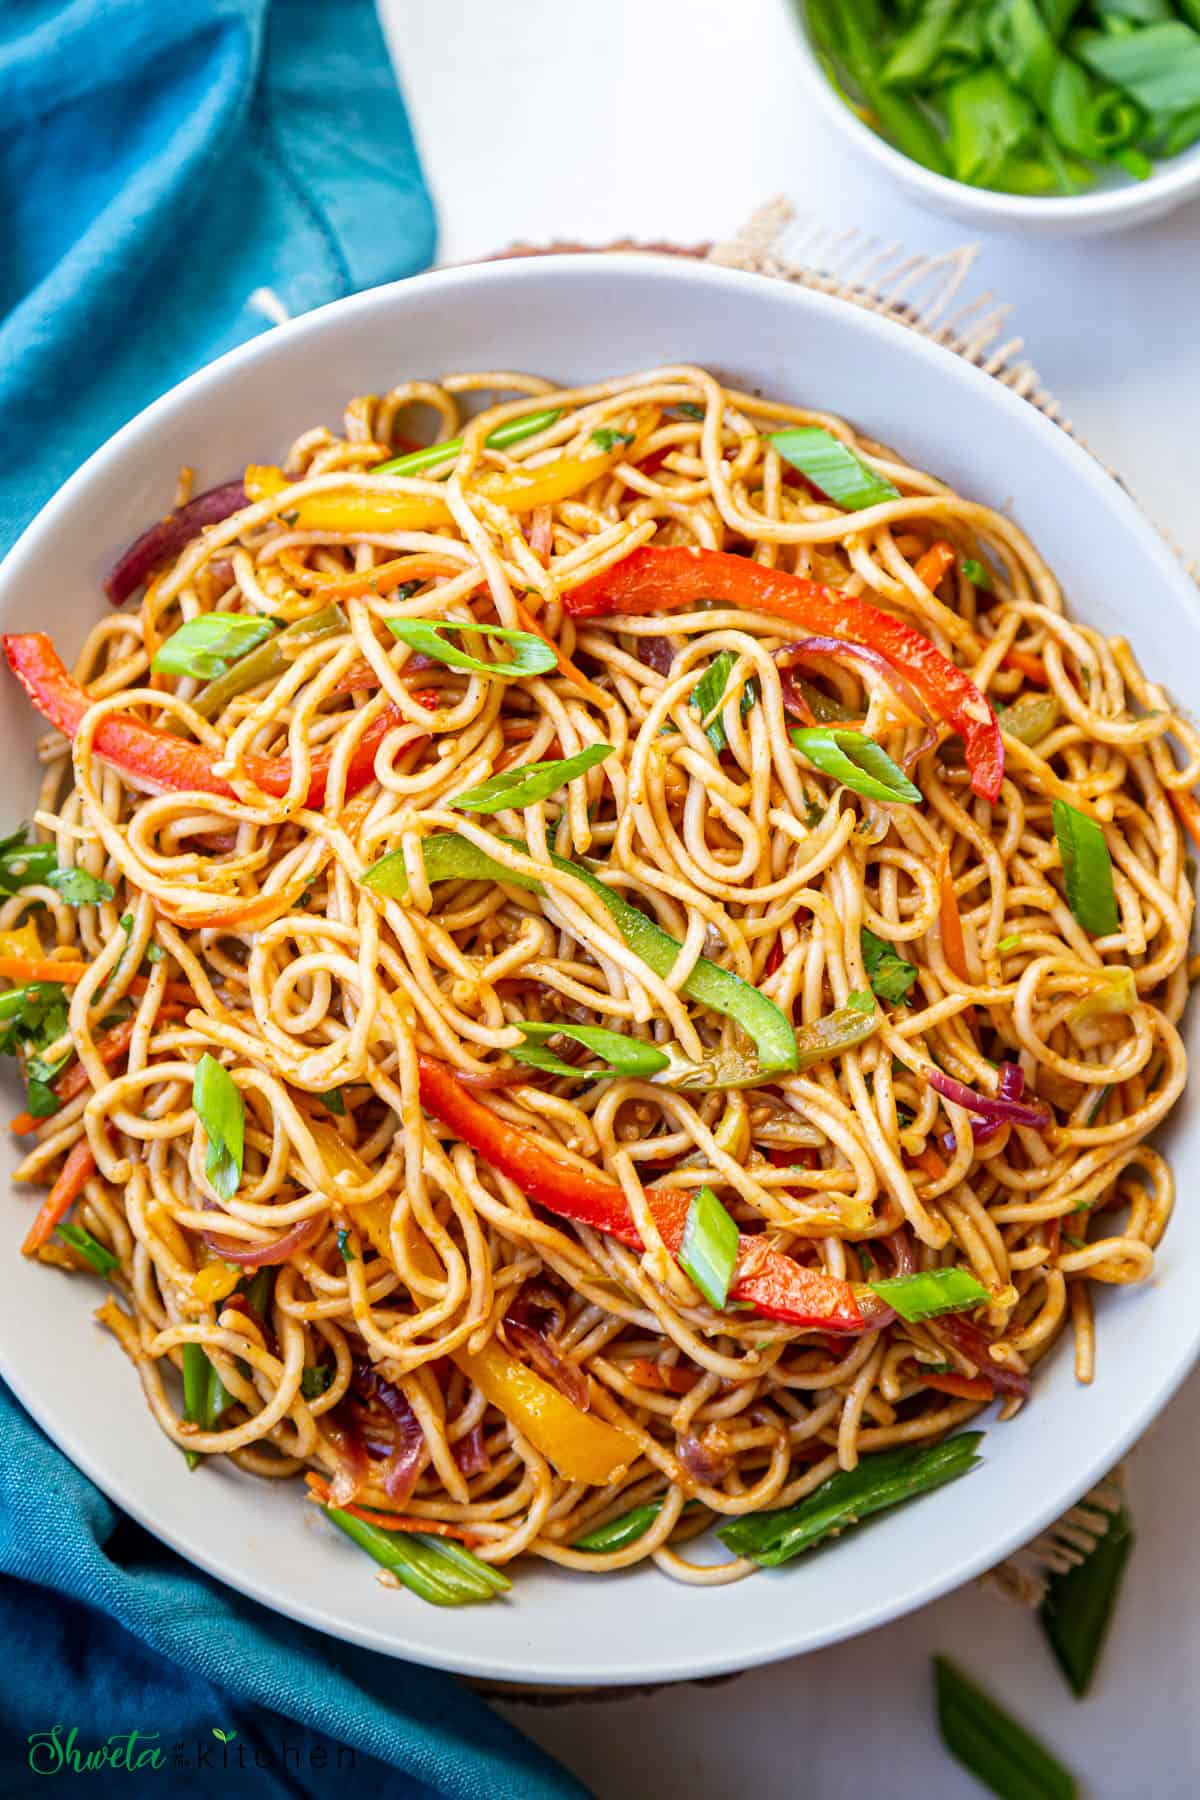

image_path                 Title  \
14  /kaggle/input/tastyyfood/Food/white-sauce-past...  Silky Sauce Symphony   

                                    full_instructions  \
14  Step 1: Boil pasta. Take your time to ensure i...   

                                     Dish_at_a_Glance  
14  Boil pasta, prepare white sauce with butter, f...

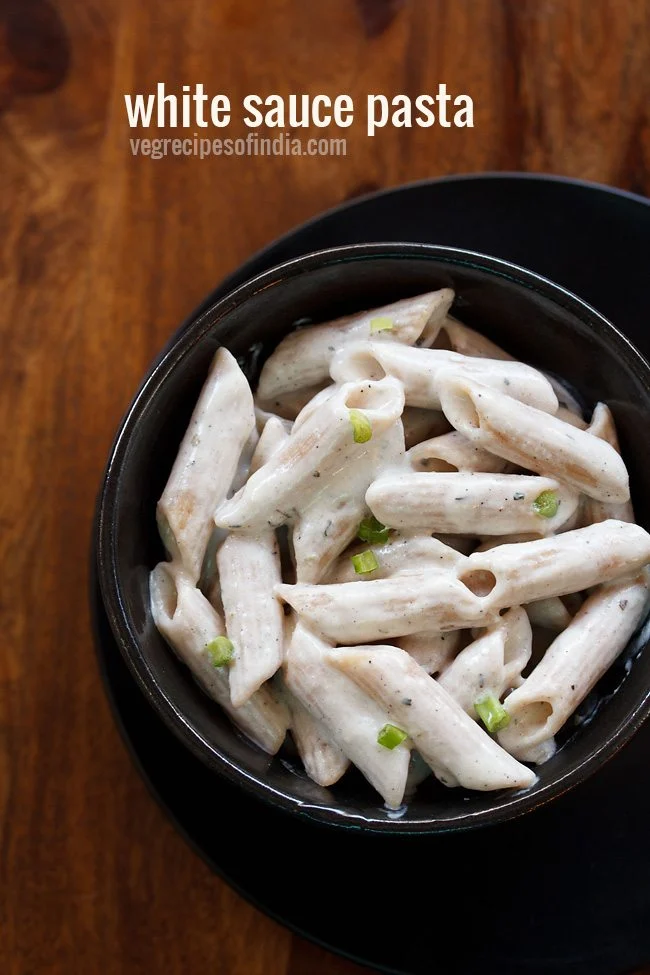

In [34]:
dishes = [
    {
        "image_path": "/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg",
        "Title": "Melted Morning Surprise",
        "full_instructions": "Step 1: Whisk eggs in a bowl; add milk and season with salt and white pepper. Whisk until egg mixture is foamy, 2 to 3 minutes. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Melt butter in a small, nonstick skillet over medium-low heat. Pour in egg mixture and swirl the skillet, so the bottom is evenly covered with egg. Cook until egg starts to set, about 1 minute. Lift edges with a spatula and tilt the skillet so uncooked egg can flow towards the bottom of the skillet to set. Repeat until no visible liquid egg remains. Make sure to monitor the heat carefully to avoid burning. Step 3: Carefully flip omelette; cook until warmed through, 30 seconds to 1 minute. Sprinkle Emmentaler cheese down the middle of omelette; fold in half. Cook until cheese is melted, about 20 seconds. Slide omelette onto a plate. This step is crucial for the texture and flavor.",
        "Dish_at_a_Glance": "Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg",
        "Title": "Spice Stick Fantasy",
        "full_instructions": "Step 1: Cut chicken into bite-sized pieces. Take your time to ensure ingredients are fresh and prepared properly. Step 2: In a bowl, mix yogurt, ginger-garlic paste, turmeric, red chili powder, garam masala, lemon juice, and salt. Make sure to monitor the heat carefully to avoid burning. Step 3: Marinate chicken in this mixture for at least 2 hours. This step is crucial for the texture and flavor. Step 4: Thread marinated chicken onto skewers. Pay attention to the consistency and adjust as needed. Step 5: Grill or bake until chicken is cooked through and slightly charred, about 12-15 minutes, turning occasionally. Serve hot with mint chutney. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg",
        "Title": "Street Style Favorite",
        "full_instructions": "Step 1: Soak chickpeas overnight. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Pressure cook chickpeas with water, salt, and tea bags for color. Make sure to monitor the heat carefully to avoid burning. Step 3: Heat oil in a pan, add cumin seeds, onions, ginger-garlic paste, tomatoes, and spices. This step is crucial for the texture and flavor. Step 4: Add cooked chickpeas and simmer. Pay attention to the consistency and adjust as needed. Step 5: For bhature, mix flour, yogurt, baking soda, salt, and water to make soft dough. Serve immediately for best taste. Step 6: Roll dough into rounds and deep fry until puffed. Serve chhole with hot bhature. Garnish attractively to enhance presentation.",
        "Dish_at_a_Glance": "Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg",
        "Title": "Veggie Crunch Stack",
        "full_instructions": "Step 1: Mix mashed potatoes, carrots, beans, corn, breadcrumbs, and spices. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Shape into patties and shallow fry until golden. Make sure to monitor the heat carefully to avoid burning. Step 3: Toast burger buns. This step is crucial for the texture and flavor. Step 4: Assemble with lettuce, tomato, cucumber, onion, and your favorite sauce. Pay attention to the consistency and adjust as needed. Step 5: Place patty inside bun and serve with fries. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Mix mashed veggies with spices and breadcrumbs, shape into patties, shallow-fry until crisp. Toast buns, layer with fresh toppings, and assemble burger."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/american-style-pancakes-87119e3.jpg",
        "Title": "Morning Griddle Flips",
        "full_instructions": "Step 1: Mix flour, sugar, baking powder, and salt in a bowl. Take your time to ensure ingredients are fresh and prepared properly. Step 2: In another bowl, whisk milk, egg, and melted butter. Make sure to monitor the heat carefully to avoid burning. Step 3: Combine wet and dry ingredients; mix until just combined. This step is crucial for the texture and flavor. Step 4: Heat a griddle, pour batter, and cook until bubbles form. Pay attention to the consistency and adjust as needed. Step 5: Flip and cook the other side. Serve with maple syrup. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Mix batter from flour, sugar, baking powder, milk, egg, and butter; cook on griddle until bubbles form, flip, cook other side, and serve with syrup."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/cheese_burstpizza.jpeg",
        "Title": "Cheese Burst Classic",
        "full_instructions": "Step 1: Prepare pizza dough and let it rise. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Roll out dough, spread tomato sauce, and top with shredded mozzarella, chicken pieces, and vegetables. Make sure to monitor the heat carefully to avoid burning. Step 3: Add extra cheese in the center for the burst. This step is crucial for the texture and flavor. Step 4: Bake at 220°C until crust is golden and cheese is bubbly. Pay attention to the consistency and adjust as needed. Step 5: Serve hot. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Prepare pizza dough, top with tomato sauce, cheese, chicken, and veggies; add extra cheese center, bake until crust is golden and cheese bubbles."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/chicken_biryani.jpg",
        "Title": "Layered Aroma Pot",
        "full_instructions": "Step 1: Marinate chicken with yogurt, spices, and herbs. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Soak basmati rice. Make sure to monitor the heat carefully to avoid burning. Step 3: Cook rice halfway. This step is crucial for the texture and flavor. Step 4: Layer marinated chicken and rice in a pot. Pay attention to the consistency and adjust as needed. Step 5: Seal and cook on low heat until done. Serve immediately for best taste. Step 6: Garnish with fried onions and serve. Garnish attractively to enhance presentation.",
        "Dish_at_a_Glance": "Marinate chicken with yogurt and spices, soak rice, cook rice halfway, layer chicken and rice in pot, seal and cook slowly, garnish with fried onions."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/chicken_momo.jpg",
        "Title": "Steamed Pocket Treats",
        "full_instructions": "Step 1: Mix minced chicken, onions, garlic, ginger, and spices. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Prepare dough from flour and water. Make sure to monitor the heat carefully to avoid burning. Step 3: Roll small circles, fill with chicken mix, and pleat to seal. This step is crucial for the texture and flavor. Step 4: Steam momos for 10-12 minutes. Pay attention to the consistency and adjust as needed. Step 5: Serve with spicy tomato chutney. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Mix minced chicken with spices, prepare dough, fill and seal small circles, steam momos until cooked, serve with spicy tomato chutney."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/honeychilli.jpg",
        "Title": "Crispy Glaze Toss",
        "full_instructions": "Step 1: Cut potatoes into strips and deep fry until crispy. Take your time to ensure ingredients are fresh and prepared properly. Step 2: In a pan, sauté garlic, ginger, green chilies, and onions. Make sure to monitor the heat carefully to avoid burning. Step 3: Add soy sauce, vinegar, ketchup, and honey. This step is crucial for the texture and flavor. Step 4: Toss in fried potatoes and coat well. Pay attention to the consistency and adjust as needed. Step 5: Garnish with sesame seeds and serve. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Deep-fry potato strips until crispy, sauté aromatics, add sauces and honey, toss potatoes in sauce, garnish with sesame seeds, and serve hot."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/munchurian.jpg",
        "Title": "Golden Globe Mix",
        "full_instructions": "Step 1: Grate and mix vegetables with flour and spices. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Shape into balls and deep fry. Make sure to monitor the heat carefully to avoid burning. Step 3: In a pan, sauté garlic, ginger, green chilies, and onions. This step is crucial for the texture and flavor. Step 4: Add sauces and water to make gravy. Pay attention to the consistency and adjust as needed. Step 5: Add fried balls and simmer. Serve immediately for best taste. Step 6: Garnish with spring onions and serve. Garnish attractively to enhance presentation.",
        "Dish_at_a_Glance": "Grate vegetables, mix with flour and spices, shape into balls, deep-fry, prepare spicy gravy, add fried balls, simmer briefly, garnish and serve."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/pavbhaji.jpg",
        "Title": "Mash and Toast Combo",
        "full_instructions": "Step 1: Boil and mash mixed vegetables. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Heat oil, add onions, tomatoes, and spices. Make sure to monitor the heat carefully to avoid burning. Step 3: Add mashed vegetables and cook until thick. This step is crucial for the texture and flavor. Step 4: Toast buttered pav (bread rolls). Pay attention to the consistency and adjust as needed. Step 5: Serve bhaji with pav and chopped onions. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Boil and mash mixed vegetables, cook with spices into thick bhaji, toast buttered pav buns, serve bhaji with pav and chopped onions."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/rajmachawal.jpg",
        "Title": "Warm Bowl Comfort",
        "full_instructions": "Step 1: Soak kidney beans overnight. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Pressure cook with water and salt. Make sure to monitor the heat carefully to avoid burning. Step 3: In a pan, sauté onions, tomatoes, and spices. This step is crucial for the texture and flavor. Step 4: Add cooked beans and simmer. Pay attention to the consistency and adjust as needed. Step 5: Serve hot with steamed rice. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Soak and pressure cook kidney beans, sauté onions and tomatoes with spices, simmer beans in masala, serve hot with steamed rice."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/shahipaneer.jpg",
        "Title": "Creamy Cubes Mix",
        "full_instructions": "Step 1: Sauté onions, garlic, ginger, and tomatoes. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Blend into a smooth paste. Make sure to monitor the heat carefully to avoid burning. Step 3: Add cream, spices, and paneer cubes. This step is crucial for the texture and flavor. Step 4: Simmer until paneer is soft and gravy is thick. Pay attention to the consistency and adjust as needed. Step 5: Garnish with cream and coriander. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Sauté aromatics, blend into paste, add cream, spices, and paneer cubes, simmer until thick and soft, garnish with cream and coriander."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/vegetable-noodles.jpg",
        "Title": "Quick Toss Fix",
        "full_instructions": "Step 1: Boil noodles and drain. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Heat oil, stir-fry garlic, ginger, and vegetables. Make sure to monitor the heat carefully to avoid burning. Step 3: Add soy sauce, vinegar, and seasonings. This step is crucial for the texture and flavor. Step 4: Toss in noodles and mix well. Pay attention to the consistency and adjust as needed. Step 5: Garnish with spring onions and serve. Serve immediately for best taste.",
        "Dish_at_a_Glance": "Boil noodles, stir-fry garlic, ginger, and vegetables, add soy sauce and vinegar, toss noodles with sauce, garnish with spring onions."
    },
    {
        "image_path": "/kaggle/input/tastyyfood/Food/white-sauce-pasta-recipe.jpg",
        "Title": "Silky Sauce Symphony",
        "full_instructions": "Step 1: Boil pasta. Take your time to ensure ingredients are fresh and prepared properly. Step 2: Melt butter, add flour, and cook. Make sure to monitor the heat carefully to avoid burning. Step 3: Gradually add milk, stirring until smooth. This step is crucial for the texture and flavor. Step 4: Add cheese, salt, and pepper. Pay attention to the consistency and adjust as needed. Step 5: Mix in boiled pasta and vegetables. Serve immediately for best taste. Step 6: Garnish with herbs and serve. Garnish attractively to enhance presentation.",
        "Dish_at_a_Glance": "Boil pasta, prepare white sauce with butter, flour, and milk, add cheese and seasoning, mix pasta and vegetables, garnish with herbs, and serve warm."
    }
]
df = pd.DataFrame(dishes)
from IPython.display import Image, display
for i, row in df.iterrows():
    display(row.to_frame().T)
    try:
        display(Image(filename=row["image_path"]))
    except FileNotFoundError:
        print(f"Image not found: {row['image_path']}")

image_path                 Title  \
0  /kaggle/input/test-set/testset/AR-19344-Homema...  Layered Melt Madness   

                                   full_instructions  
0  Step 1: Cook ground beef and onions in a skill...

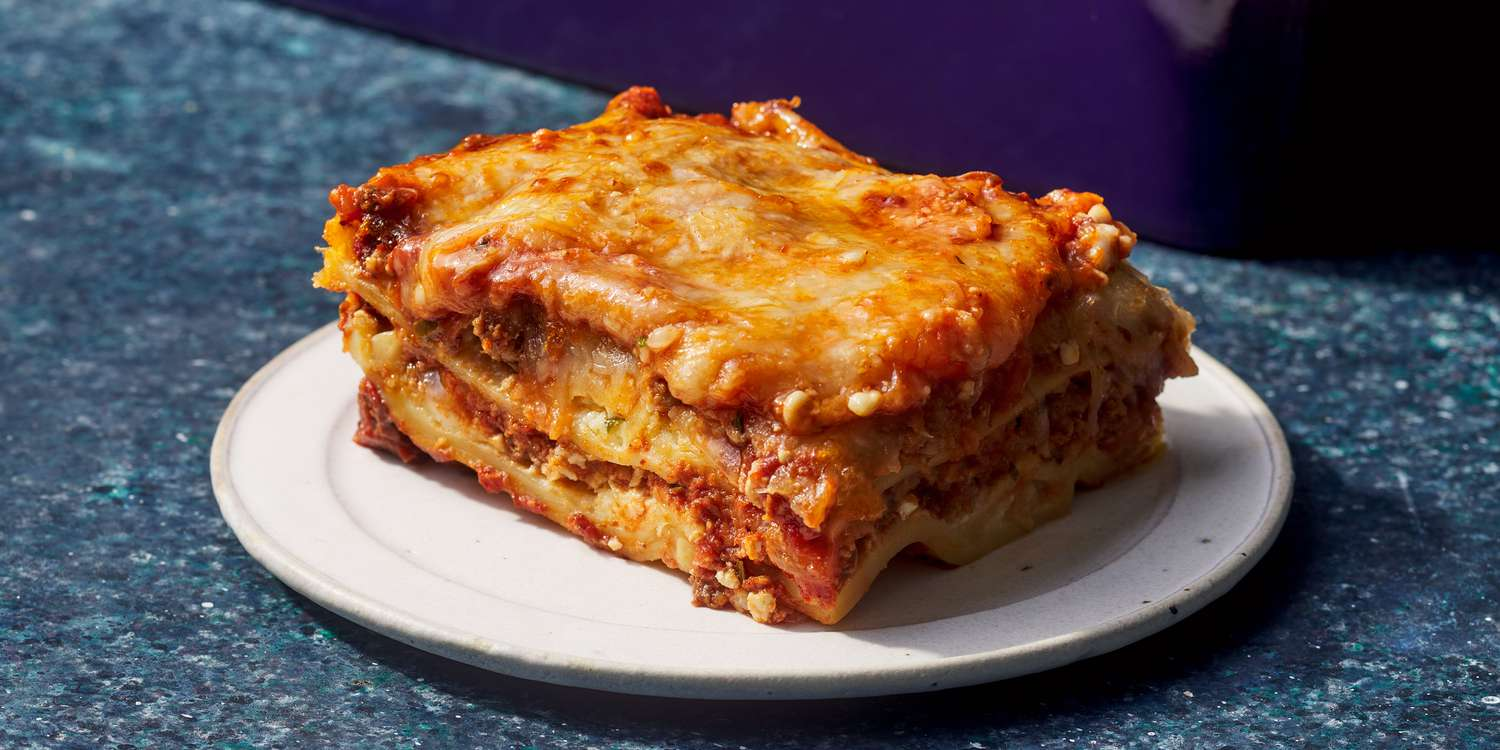

image_path                Title  \
1  /kaggle/input/test-set/testset/Mutton-Korma-2-...  Royal Spice Reverie   

                                   full_instructions  
1  Step 1: Marinate mutton with yogurt, ginger-ga...

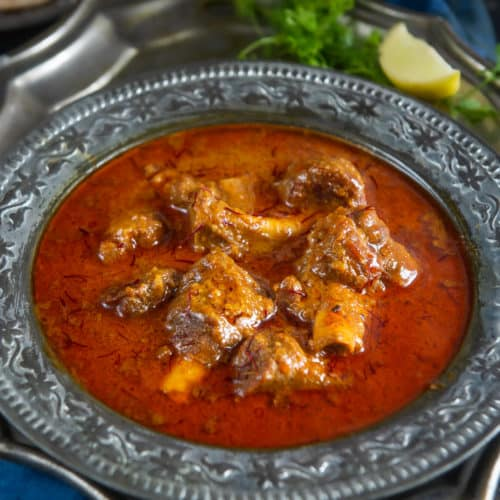

image_path               Title  \
2  /kaggle/input/test-set/testset/Simply-Recipes-...  Cheesy Fold Fiesta   

                                   full_instructions  
2  Step 1: Sauté sliced peppers and onions until ...

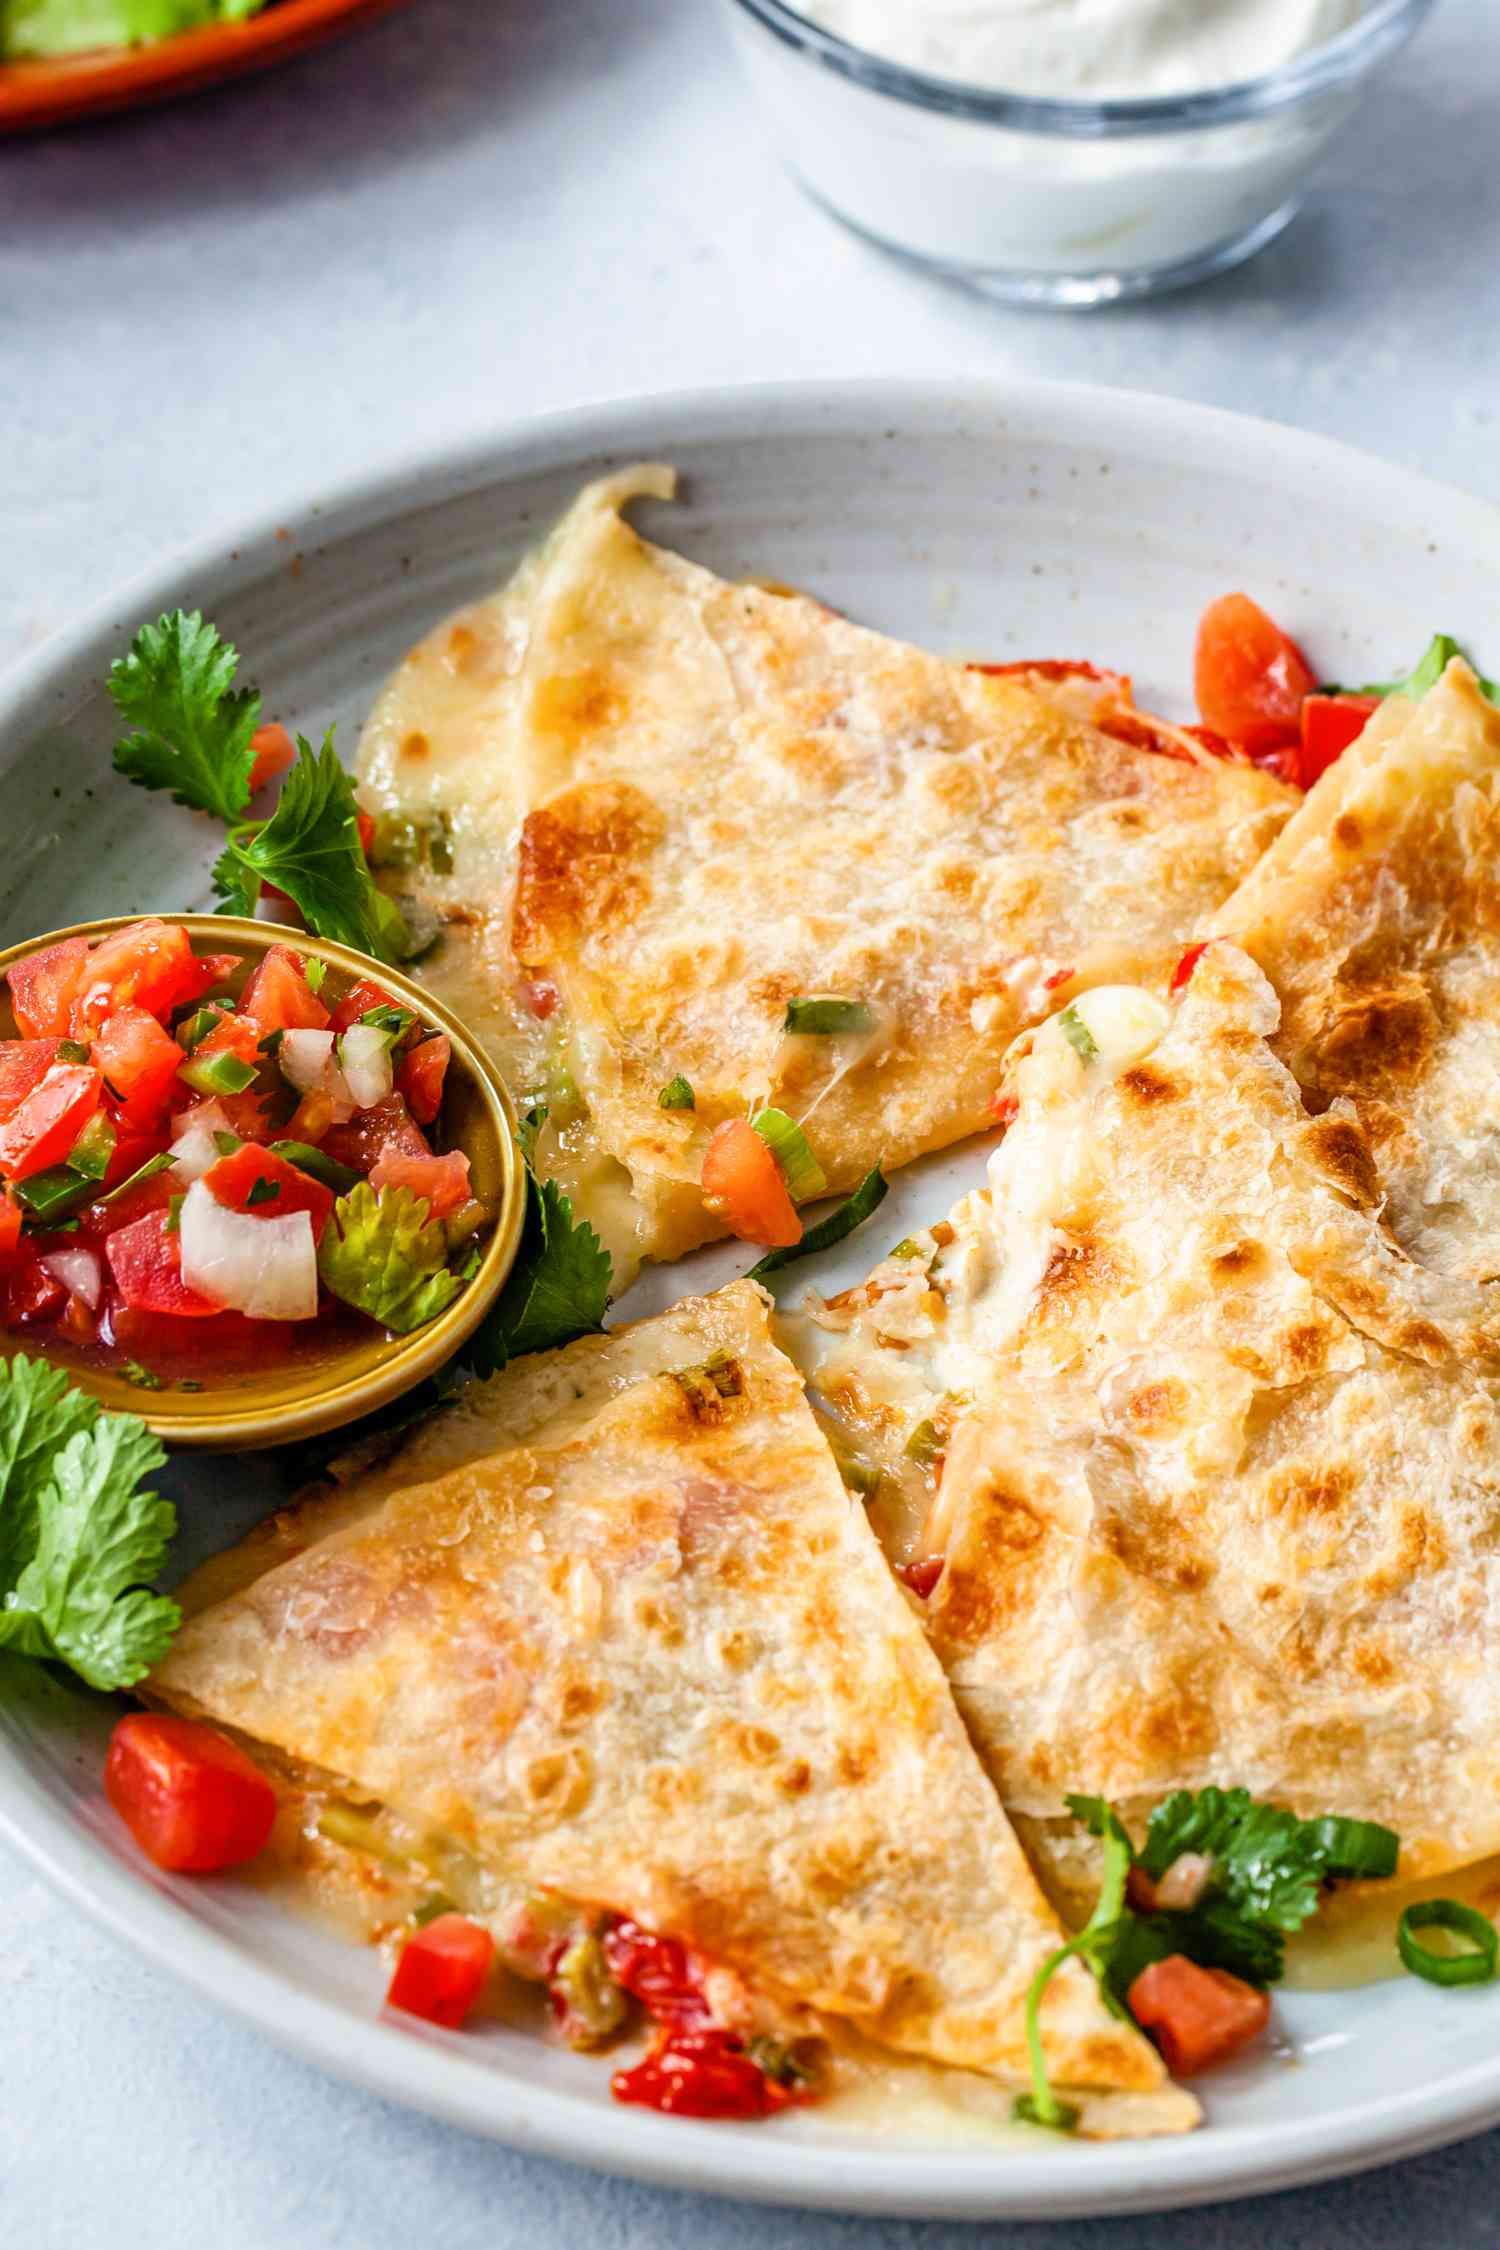

image_path                   Title  \
3  /kaggle/input/test-set/testset/classic_crepes_...  Delicate Drape Delight   

                                   full_instructions  
3  Step 1: Whisk flour, eggs, milk, water, melted...

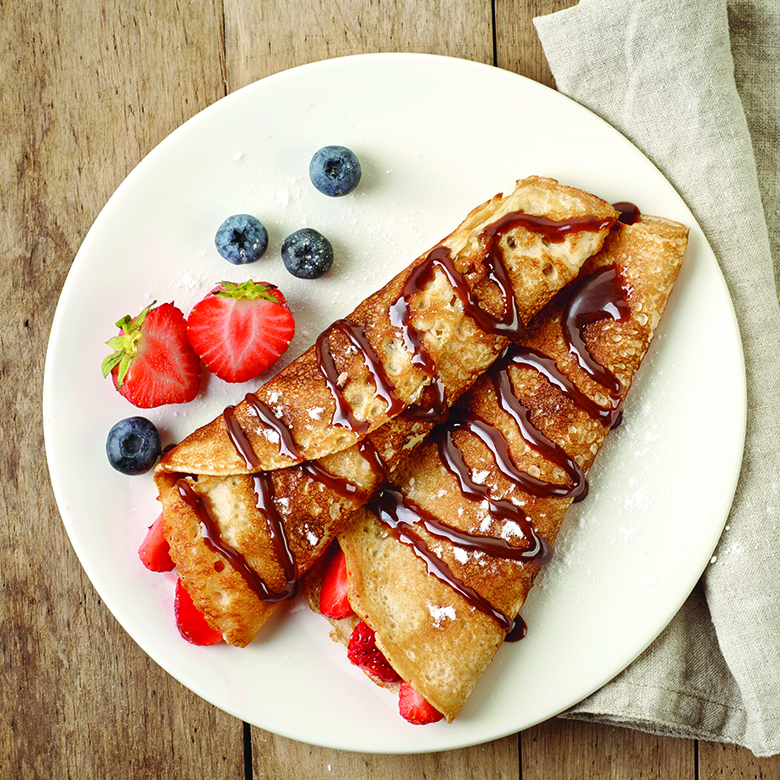

image_path                   Title  \
4  /kaggle/input/test-set/testset/images.jpg  Pastel Puff Perfection   

                                   full_instructions  
4  Step 1: Sift almond flour and powdered sugar t...

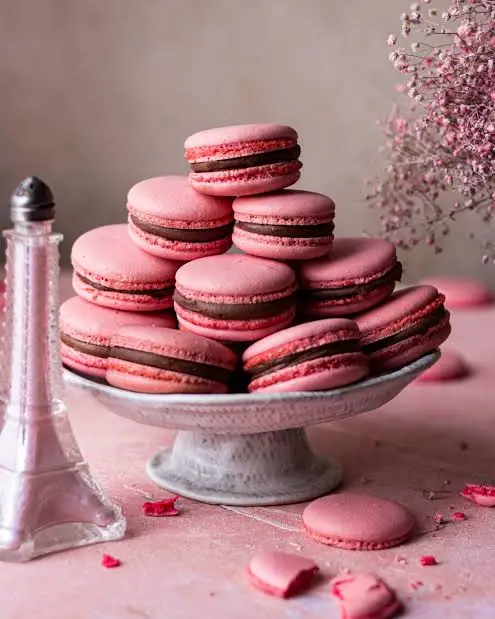

In [37]:
dishes = [
    {
        "image_path": "/kaggle/input/test-set/testset/AR-19344-Homemade-Lasagna-beauty-2x1-98da45c3a5854a2b8901a92123ccb6f1.jpg",
        "Title": "Layered Melt Madness",
        "full_instructions": (
            "Step 1: Cook ground beef and onions in a skillet until browned. Add tomato sauce and simmer for 10 minutes. "
            "Step 2: Boil lasagna noodles until al dente, drain and set aside. "
            "Step 3: Mix ricotta cheese with egg and parsley. "
            "Step 4: Layer noodles, meat sauce, ricotta mixture, and shredded mozzarella in a baking dish. Repeat layers. "
            "Step 5: Cover with foil and bake at 375°F for 40 minutes. Remove foil and bake another 15 minutes until cheese is bubbly. Let rest before serving."
        )
    },
    {
        "image_path": "/kaggle/input/test-set/testset/Mutton-Korma-2-3-500x500.jpg",
        "Title": "Royal Spice Reverie",
        "full_instructions": (
            "Step 1: Marinate mutton with yogurt, ginger-garlic paste, and spices for at least 1 hour. "
            "Step 2: Sauté onions in ghee until golden, add marinated mutton and cook covered on medium heat for 30 minutes. "
            "Step 3: Add fried onions and water, simmer on low heat until mutton is tender, about 1-1.5 hours. "
            "Step 4: Stir in cream and garnish with nuts. Serve hot with naan or rice."
        )
    },
    {
        "image_path": "/kaggle/input/test-set/testset/Simply-Recipes-Quesadilla-LEAD-1-b8e325610a7c46e1b6b6c2208d7ed4ee.jpg",
        "Title": "Cheesy Fold Fiesta",
        "full_instructions": (
            "Step 1: Sauté sliced peppers and onions until soft. Remove and set aside. "
            "Step 2: Cook seasoned chicken strips until golden and cooked through. "
            "Step 3: Heat a tortilla in a skillet, sprinkle cheese on half, add chicken and veggies, then fold. "
            "Step 4: Cook until cheese melts and tortilla is crisp, flipping once. Cut into wedges and serve with salsa and sour cream."
        )
    },
    {
        "image_path": "/kaggle/input/test-set/testset/classic_crepes_1.jpg",
        "Title": "Delicate Drape Delight",
        "full_instructions": (
            "Step 1: Whisk flour, eggs, milk, water, melted butter, and a pinch of salt into a smooth batter. Let rest for 30 minutes. "
            "Step 2: Heat a lightly buttered skillet over medium heat. Pour 3-4 tablespoons of batter, tilting to spread thinly. "
            "Step 3: Cook until edges lift, flip and cook briefly on the other side. "
            "Step 4: Stack cooked crepes and serve with sweet or savory fillings."
        )
    },
    {
        "image_path": "/kaggle/input/test-set/testset/images.jpg",
        "Title": "Pastel Puff Perfection",
        "full_instructions": (
            "Step 1: Sift almond flour and powdered sugar together. "
            "Step 2: Whip egg whites with cream of tartar until soft peaks form, gradually add sugar and whip to stiff peaks. "
            "Step 3: Gently fold dry ingredients into egg whites until batter flows like lava. "
            "Step 4: Pipe rounds onto parchment-lined baking sheets, tap to remove air bubbles, and rest 40-60 minutes. "
            "Step 5: Bake at 300°F for 12-15 minutes, cool completely before filling with buttercream or ganache."
        )
    }
]

df = pd.DataFrame(dishes)
from IPython.display import Image, display
for i, row in df.iterrows():
    display(row.to_frame().T)
    try:
        display(Image(filename=row["image_path"]))
    except FileNotFoundError:
        print(f"Image not found: {row['image_path']}")


In [24]:
import torch

# Step 1: Load few-shot example images
pixel_values1 = load_image('/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg', max_num=12)
pixel_values2 = load_image('/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg', max_num=12)
pixel_values3 = load_image('/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg', max_num=12)
pixel_values4 = load_image('/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg', max_num=12)

# Step 2: Load new input image (uploaded now)
pixel_values_input = load_image('/kaggle/input/test-set/testset/AR-19344-Homemade-Lasagna-beauty-2x1-98da45c3a5854a2b8901a92123ccb6f1.jpg', max_num=12)

# Step 3: Concatenate all images
pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4, pixel_values_input), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0), pixel_values3.size(0), pixel_values4.size(0), pixel_values_input.size(0)]

# Convert input tensor dtype to bfloat16 to match model parameters
pixel_values = pixel_values.to(torch.bfloat16)

# Step 4: Few-shot prompt
prompt = """you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below

Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape mashed veggie mixture into patties, then shallow-fry until crisp. Toast buns, layer with toppings, and assemble burger.

New Input:
Image: <image>
Title: "Layered Melt Madness"
Instruction:"""

generation_config = dict(max_new_tokens=1024, do_sample=True)

# Step 5: Model call
response, history = model.chat(
    tokenizer, pixel_values, prompt, generation_config,
    num_patches_list=num_patches_list,
    history=None, return_history=True
)

print(f'User:\n{prompt}\n\nAssistant:\n{response}')


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User:
you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take referances from the examples provided below

Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape 

In [31]:
import torch

# Step 1: Load few-shot example images
pixel_values1 = load_image('/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg', max_num=12)
pixel_values2 = load_image('/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg', max_num=12)
pixel_values3 = load_image('/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg', max_num=12)
pixel_values4 = load_image('/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg', max_num=12)

# Step 2: Load new input image (uploaded now)
pixel_values_input = load_image('/kaggle/input/test-set/testset/Mutton-Korma-2-3-500x500.jpg', max_num=12)

# Step 3: Concatenate all images
pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4, pixel_values_input), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0), pixel_values3.size(0), pixel_values4.size(0), pixel_values_input.size(0)]

# Convert input tensor dtype to bfloat16 to match model parameters
pixel_values = pixel_values.to(torch.bfloat16)

# Step 4: Few-shot prompt
prompt = """you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below
Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape mashed veggie mixture into patties, then shallow-fry until crisp. Toast buns, layer with toppings, and assemble burger.

New Input:
Image: <image>
Title: "Royal Spice Reverie"
Instruction:"""

generation_config = dict(max_new_tokens=1024, do_sample=True)

# Step 5: Model call
response, history = model.chat(
    tokenizer, pixel_values, prompt, generation_config,
    num_patches_list=num_patches_list,
    history=None, return_history=True
)

print(f'User:\n{prompt}\n\nAssistant:\n{response}')


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User:
you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below
Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape m

In [27]:
import torch

# Step 1: Load few-shot example images
pixel_values1 = load_image('/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg', max_num=12)
pixel_values2 = load_image('/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg', max_num=12)
pixel_values3 = load_image('/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg', max_num=12)
pixel_values4 = load_image('/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg', max_num=12)

# Step 2: Load new input image (uploaded now)
pixel_values_input = load_image('/kaggle/input/test-set/testset/Simply-Recipes-Quesadilla-LEAD-1-b8e325610a7c46e1b6b6c2208d7ed4ee.jpg', max_num=12)

# Step 3: Concatenate all images
pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4, pixel_values_input), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0), pixel_values3.size(0), pixel_values4.size(0), pixel_values_input.size(0)]

# Convert input tensor dtype to bfloat16 to match model parameters
pixel_values = pixel_values.to(torch.bfloat16)

# Step 4: Few-shot prompt
prompt = """you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below
Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape mashed veggie mixture into patties, then shallow-fry until crisp. Toast buns, layer with toppings, and assemble burger.

New Input:
Image: <image>
Title: "Cheesy Fold Fiesta"
Instruction:"""

generation_config = dict(max_new_tokens=1024, do_sample=True)

# Step 5: Model call
response, history = model.chat(
    tokenizer, pixel_values, prompt, generation_config,
    num_patches_list=num_patches_list,
    history=None, return_history=True
)

print(f'User:\n{prompt}\n\nAssistant:\n{response}')


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User:
you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below
Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape m

In [28]:

import torch

# Step 1: Load few-shot example images
pixel_values1 = load_image('/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg', max_num=12)
pixel_values2 = load_image('/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg', max_num=12)
pixel_values3 = load_image('/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg', max_num=12)
pixel_values4 = load_image('/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg', max_num=12)

# Step 2: Load new input image (uploaded now)
pixel_values_input = load_image('/kaggle/input/test-set/testset/classic_crepes_1.jpg', max_num=12)

# Step 3: Concatenate all images
pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4, pixel_values_input), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0), pixel_values3.size(0), pixel_values4.size(0), pixel_values_input.size(0)]

# Convert input tensor dtype to bfloat16 to match model parameters
pixel_values = pixel_values.to(torch.bfloat16)

# Step 4: Few-shot prompt
prompt = """you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below

Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape mashed veggie mixture into patties, then shallow-fry until crisp. Toast buns, layer with toppings, and assemble burger.

New Input:
Image: <image>
Title: "Delicate Drape Delight"
Instruction:"""

generation_config = dict(max_new_tokens=1024, do_sample=True)

# Step 5: Model call
response, history = model.chat(
    tokenizer, pixel_values, prompt, generation_config,
    num_patches_list=num_patches_list,
    history=None, return_history=True
)

print(f'User:\n{prompt}\n\nAssistant:\n{response}')


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User:
you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below

Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape 

In [29]:

import torch

# Step 1: Load few-shot example images
pixel_values1 = load_image('/kaggle/input/tastyyfood/Food/Cheese-omelette-45155e3.jpg', max_num=12)
pixel_values2 = load_image('/kaggle/input/tastyyfood/Food/Chicken-Tikka-99647a6.jpg', max_num=12)
pixel_values3 = load_image('/kaggle/input/tastyyfood/Food/Chole_Bhature_At_Local_Street.jpg', max_num=12)
pixel_values4 = load_image('/kaggle/input/tastyyfood/Food/Secret-Veg-Cheeseburgers-c981dd6.jpg', max_num=12)

# Step 2: Load new input image (uploaded now)
pixel_values_input = load_image('/kaggle/input/test-set/testset/images.jpg', max_num=12)

# Step 3: Concatenate all images
pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4, pixel_values_input), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0), pixel_values3.size(0), pixel_values4.size(0), pixel_values_input.size(0)]

# Convert input tensor dtype to bfloat16 to match model parameters
pixel_values = pixel_values.to(torch.bfloat16)

# Step 4: Few-shot prompt
prompt = """you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below

Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape mashed veggie mixture into patties, then shallow-fry until crisp. Toast buns, layer with toppings, and assemble burger.

New Input:
Image: <image>
Title: "Pastel Puff Perfection"
Instruction:"""

generation_config = dict(max_new_tokens=1024, do_sample=True)

# Step 5: Model call
response, history = model.chat(
    tokenizer, pixel_values, prompt, generation_config,
    num_patches_list=num_patches_list,
    history=None, return_history=True
)

print(f'User:\n{prompt}\n\nAssistant:\n{response}')


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User:
you are a very very smart AI model. now when the user gives you an image and a noisy textual title of that image you have to show your smartness and give a very concise 2 line recipe to prepare that dish from scratch please dont disappoint me. take references from the examples provided below

Example 1:
Image: <image>
Title: "Melted Morning Surprise"
Instruction: Whisk eggs with milk and seasonings until foamy, then cook gently in a non-stick skillet. Flip, fill with cheese, fold, and cook briefly until melted.

Example 2:
Image: <image>
Title: "Spice Stick Fantasy"
Instruction: Marinate chicken chunks in spiced yogurt mixture and thread onto skewers. Grill or bake until charred and fully cooked.

Example 3:
Image: <image>
Title: "Street Style Favorite"
Instruction: Cook soaked chickpeas with spices and tea bags for deep color and flavor. Prepare bhature dough, roll out, and deep-fry until puffed.

Example 4:
Image: <image>
Title: "Veggie Crunch Stack"
Instruction: Mix and shape 

In [44]:
!pip install rouge_score

In [45]:
from rouge_score import rouge_scorer
import pandas as pd

# Define reference summaries (manually written concise summaries)
# These should correspond to the test set images used in the notebook
reference_summaries = {
    "Mutton-Korma-2-3-500x500.jpg": "Marinate mutton in yogurt and spices, then cook with onions and tomatoes until tender. Add cream and nuts, simmer briefly, and serve hot.",
    "Simply-Recipes-Quesadilla-LEAD-1-b8e325610a7c46e1b6b6c2208d7ed4ee.jpg": "Layer tortillas with cheese and fillings, then cook on a skillet until crispy and melted. Cut into wedges and serve with salsa.",
    "classic_crepes_1.jpg": "Whisk flour, eggs, milk, and water into a smooth batter, then cook thin layers in a hot skillet. Fill with sweet or savory toppings and fold.",
    "images.jpg": "Prepare a light batter with flour and eggs, spread into thin rounds, and bake until puffed and golden. Dust with powdered sugar and serve."
}

# Generated summaries from the notebook
generated_summaries = {
    "Mutton-Korma-2-3-500x500.jpg": "Braise lamb chops in a rich, spiced sauce, let it simmer until tender. Squeeze lemons for zest, mix with chickpeas for spiced yogurt, form into patties, and deep-fry until golden.",
    "Simply-Recipes-Quesadilla-LEAD-1-b8e325610a7c46e1b6b6c2208d7ed4ee.jpg": "Heat a skillet over medium heat. Season pan-fried tortillas with garlic powder and grated cheese. Serve with salsa, avocado, and a dollop of sour cream.",
    "classic_crepes_1.jpg": "Whisk flour, eggs, and water to create a thick batter. Dip each roll in the batter and fry until golden and cooked through. Arrange the rolled potatoes on a plate, drizzle with sauce, and garnish with berries for a visually appealing display.",
    "images.jpg": "Whisk together egg whites and sugar until stiff peaks form. Pipe onto flaky pastry crust. Bake until golden. Let chill before serving."
}

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each image-title pair
results = []
for image_name in reference_summaries.keys():
    reference = reference_summaries[image_name]
    generated = generated_summaries[image_name]
    
    # Compute ROUGE scores
    scores = scorer.score(reference, generated)
    
    # Store results
    results.append({
        'Image': image_name,
        'ROUGE-1 Precision': scores['rouge1'].precision,
        'ROUGE-1 Recall': scores['rouge1'].recall,
        'ROUGE-1 F1': scores['rouge1'].fmeasure,
        'ROUGE-2 Precision': scores['rouge2'].precision,
        'ROUGE-2 Recall': scores['rouge2'].recall,
        'ROUGE-2 F1': scores['rouge2'].fmeasure,
        'ROUGE-L Precision': scores['rougeL'].precision,
        'ROUGE-L Recall': scores['rougeL'].recall,
        'ROUGE-L F1': scores['rougeL'].fmeasure
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print results
print("ROUGE Scores for Generated Summaries:")
print(results_df)

# Calculate average ROUGE scores
avg_scores = {
    'Avg ROUGE-1 Precision': results_df['ROUGE-1 Precision'].mean(),
    'Avg ROUGE-1 Recall': results_df['ROUGE-1 Recall'].mean(),
    'Avg ROUGE-1 F1': results_df['ROUGE-1 F1'].mean(),
    'Avg ROUGE-2 Precision': results_df['ROUGE-2 Precision'].mean(),
    'Avg ROUGE-2 Recall': results_df['ROUGE-2 Recall'].mean(),
    'Avg ROUGE-2 F1': results_df['ROUGE-2 F1'].mean(),
    'Avg ROUGE-L Precision': results_df['ROUGE-L Precision'].mean(),
    'Avg ROUGE-L Recall': results_df['ROUGE-L Recall'].mean(),
    'Avg ROUGE-L F1': results_df['ROUGE-L F1'].mean()
}

print("\nAverage ROUGE Scores:")
for metric, value in avg_scores.items():
    print(f"{metric}: {value:.4f}")

ROUGE Scores for Generated Summaries:
                                               Image  ROUGE-1 Precision  \
0                       Mutton-Korma-2-3-500x500.jpg           0.258065   
1  Simply-Recipes-Quesadilla-LEAD-1-b8e325610a7c4...           0.384615   
2                               classic_crepes_1.jpg           0.285714   
3                                         images.jpg           0.318182   

   ROUGE-1 Recall  ROUGE-1 F1  ROUGE-2 Precision  ROUGE-2 Recall  ROUGE-2 F1  \
0        0.347826    0.296296           0.033333        0.045455    0.038462   
1        0.454545    0.416667           0.160000        0.190476    0.173913   
2        0.461538    0.352941           0.073171        0.120000    0.090909   
3        0.291667    0.304348           0.047619        0.043478    0.045455   

   ROUGE-L Precision  ROUGE-L Recall  ROUGE-L F1  
0           0.161290        0.217391    0.185185  
1           0.230769        0.272727    0.250000  
2           0.261905        0.42